In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
MODEL_INDEXES = {
    0: 'Mixtral 8x7B',
    1: 'Groq Llama 3 70B',
    2: 'Gemini 1.5 Flash',
    3: 'GPT 3.5 Turbo',
    4: 'Gemini 1.5 Pro',
    5: 'GPT 4 Turbo'
}

In [3]:
# Model sizes
# Note: 10**9 == billion
MODEL_SIZES = [
    46.7 * 10**9, # Mixtral 8x7B
    70 * 10**9, # Groq Llama 3 70B
    82 * 10**9, # Gemini 1.5 Flash
    100 * 10**9, # GPT 3.5 Turbo
    120 * 10**9, # Gemini 1.5 Pro
    220 * 10**9, # GPT 4 Turbo
]

In [4]:
EVALUATION_FILES_ROOT = "../evaluation_files"

In [5]:
CODE_GEN_EVALUATIONS = [
    os.path.join(EVALUATION_FILES_ROOT, 'mixtral_results_temp_0/PROMPT_CODEGEN_V1_mixtral-8x7b-32768.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'llama3_90B_results_temp_0/PROMPT_CODEGEN_V1_llama3-groq-70b-8192-tool-use-preview.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'result_gemini/results_gemini_0/gemini-1.5-flash_CODEGEN_results.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'openai_results_temp_0/CODE_GEN_V1_gpt-3.5-turbo.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'result_gemini/results_gemini_0/gemini-1.5-pro_CODEGEN_results.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'openai_results_temp_0/CODE_GEN_V1_gpt-4-turbo.csv'),
]

In [6]:
def load_evaluation(path):
    numeric_columns = ['eslint_count_original', 'eslint_count_refactored', 'closure_count_original', 'closure_count_refactored', 'runtimeOriginal', 'runtimeOptimized', 'runtimeRefactored', 'numOptimizedCorrect', 'numRefactoredCorrect', 'total']
    
    df = pd.read_csv(path)
    
    for column in numeric_columns:
        if column not in df:
            raise Exception('Column {column} not in {path}'.format(column=column, path=path))
        
        df[column] = df[column].replace(-1, np.nan)
        
    return df

In [7]:
code_gen_avg_scores = []
code_gen_avg_runtime_improvement = []

for i in range(len(MODEL_INDEXES)):
    evaluation_df = load_evaluation(CODE_GEN_EVALUATIONS[i])
    
    evaluation_df['accuracy_score'] = evaluation_df['numRefactoredCorrect'] / evaluation_df['total']
    evaluation_df['runtime_improvement'] = ((evaluation_df['runtimeOriginal'] - evaluation_df['runtimeRefactored']) / evaluation_df['runtimeOriginal']) * 100
    
    code_gen_avg_scores.append(evaluation_df['accuracy_score'].mean())
    code_gen_avg_runtime_improvement.append(evaluation_df['runtime_improvement'].mean())
    

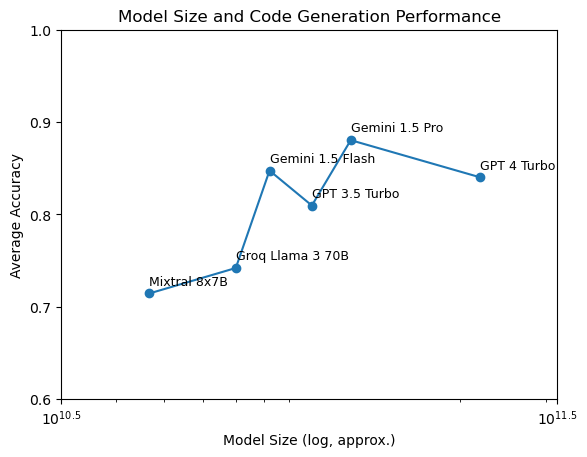

In [8]:
plt.figure()
plt.plot(MODEL_SIZES, code_gen_avg_scores, marker='o')

plt.xscale('log')
plt.xticks(ticks=[10**10.49, 10**11.5], labels=['$10^{10.5}$', '$10^{11.5}$'])
plt.yticks(np.arange(0.6, 1.01, step=0.1))

for i, label in enumerate(MODEL_INDEXES.values()):
    plt.text(MODEL_SIZES[i], code_gen_avg_scores[i] + 0.02, label, fontsize=9, ha='left', va='top')

plt.xlabel('Model Size (log, approx.)')
plt.ylabel('Average Accuracy')
plt.title('Model Size and Code Generation Performance')

plt.show()

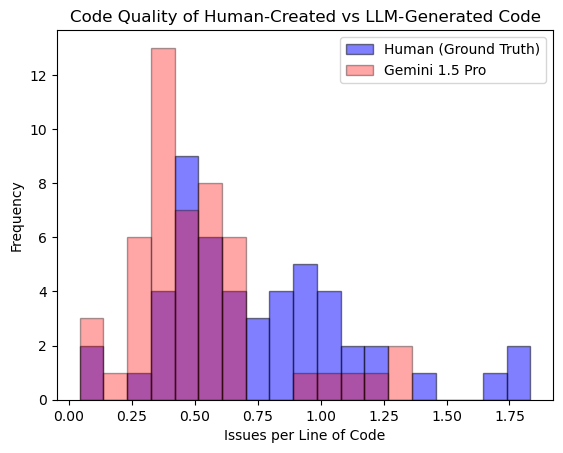

In [9]:
code_quality_df = load_evaluation(CODE_GEN_EVALUATIONS[4]) # Gemini 1.5 Pro
code_quality_df['loc_gt'] = code_quality_df['gt_code'].str.split('\n').str.len()
code_quality_df['loc_gen'] = code_quality_df['refactor_code'].str.split('\n').str.len()
code_quality_df['gt_issues_per_loc'] = code_quality_df['eslint_count_original'] / code_quality_df['loc_gt']
code_quality_df['gen_issues_per_loc'] = code_quality_df['eslint_count_refactored'] / code_quality_df['loc_gen']

min_bin = min(code_quality_df['gt_issues_per_loc'].min(), code_quality_df['gen_issues_per_loc'].min())
max_bin = max(code_quality_df['gt_issues_per_loc'].max(), code_quality_df['gen_issues_per_loc'].max())
bins = np.linspace(min_bin, max_bin, 20)

plt.hist(code_quality_df['gt_issues_per_loc'], bins=bins, alpha=0.5, label='Human (Ground Truth)', color='blue', edgecolor='black')
plt.hist(code_quality_df['gen_issues_per_loc'], bins=bins, alpha=0.35, label='Gemini 1.5 Pro', color='red', edgecolor='black')

plt.legend()
plt.xlabel('Issues per Line of Code')
plt.ylabel('Frequency')
plt.title('Code Quality of Human-Created vs LLM-Generated Code')

plt.show()


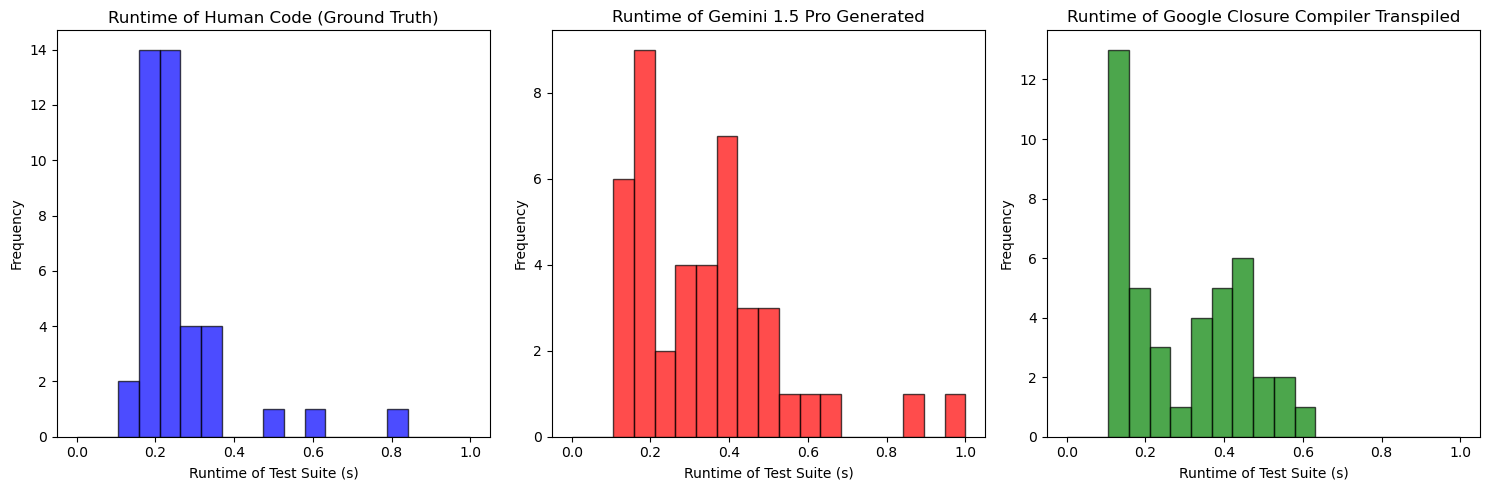

In [10]:
bins = np.linspace(0, 1, 20)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms
axes[0].hist(code_quality_df['runtimeOriginal'], bins=bins, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Runtime of Human Code (Ground Truth)')
axes[0].set_xlabel('Runtime of Test Suite (s)')
axes[0].set_ylabel('Frequency')

axes[1].hist(code_quality_df['runtimeRefactored'], bins=bins, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title('Runtime of Gemini 1.5 Pro Generated')
axes[1].set_xlabel('Runtime of Test Suite (s)')
axes[1].set_ylabel('Frequency')

axes[2].hist(code_quality_df['runtimeOptimized'], bins=bins, color='green', alpha=0.7, edgecolor='black')
axes[2].set_title('Runtime of Google Closure Compiler Transpiled')
axes[2].set_xlabel('Runtime of Test Suite (s)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
REFACTOR_NO_LINTER_EVALUATIONS = [
    os.path.join(EVALUATION_FILES_ROOT, 'mixtral_results_temp_0/PROMPT_REFACTOR_V1_mixtral-8x7b-32768.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'llama3_90B_results_temp_0/PROMPT_REFACTOR_V1_llama3-groq-70b-8192-tool-use-preview.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'result_gemini/results_gemini_0/gemini-1.5-flash_REFACTOR_results.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'openai_results_temp_0/CODE_REFACTOR_V1_gpt-3.5-turbo.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'result_gemini/results_gemini_0/gemini-1.5-pro_REFACTOR_results.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'openai_results_temp_0/PROMPT_REFACTOR_V1_gpt-4-turbo.csv'),
]

REFACTOR_LINTER_EVALUATIONS = [
    os.path.join(EVALUATION_FILES_ROOT, 'mixtral_results_temp_0/PROMPT_REFACTOR_V4_mixtral-8x7b-32768.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'llama3_90B_results_temp_0/PROMPT_REFACTOR_V4_llama3-groq-70b-8192-tool-use-preview.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'result_gemini/results_gemini_0/gemini-1.5-flash_REFACTOR_V4_results.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'openai_results_temp_0/PROMPT_REFACTOR_V4_gpt-3.5-turbo.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'result_gemini/results_gemini_0/gemini-1.5-pro_REFACTOR_V4_results.csv'),
    os.path.join(EVALUATION_FILES_ROOT, 'openai_results_temp_0/PROMPT_REFACTOR_V4_gpt-4-turbo.csv'),
]

In [12]:
refactor_no_linter_avg_scores = []
refactor_no_linter_avg_runtime_improvement = []
refactor_no_linter_style_improvement = []

for i in range(len(MODEL_INDEXES)):
    evaluation_df = load_evaluation(REFACTOR_NO_LINTER_EVALUATIONS[i])
    
    evaluation_df['accuracy_score'] = evaluation_df['numRefactoredCorrect'] / evaluation_df['total']
    evaluation_df['runtime_improvement'] = ((evaluation_df['runtimeOriginal'] - evaluation_df['runtimeRefactored']) / evaluation_df['runtimeOriginal']) * 100
    evaluation_df['style_improvement'] = ((evaluation_df['closure_count_original'] - evaluation_df['closure_count_refactored']) / evaluation_df['closure_count_original']) * 100
    
    refactor_no_linter_avg_scores.append(evaluation_df['accuracy_score'].mean())
    refactor_no_linter_avg_runtime_improvement.append(evaluation_df['runtime_improvement'].mean())
    refactor_no_linter_style_improvement.append(evaluation_df['style_improvement'].mean())


refactor_linter_avg_scores = []
refactor_linter_avg_runtime_improvement = []
refactor_linter_style_improvement = []

for i in range(len(MODEL_INDEXES)):
    evaluation_df = load_evaluation(REFACTOR_LINTER_EVALUATIONS[i])
    
    evaluation_df['accuracy_score'] = evaluation_df['numRefactoredCorrect'] / evaluation_df['total']
    evaluation_df['runtime_improvement'] = ((evaluation_df['runtimeOriginal'] - evaluation_df['runtimeRefactored']) / evaluation_df['runtimeOriginal']) * 100
    evaluation_df['style_improvement'] = ((evaluation_df['closure_count_original'] - evaluation_df['closure_count_refactored']) / evaluation_df['closure_count_original']) * 100
    
    refactor_linter_avg_scores.append(evaluation_df['accuracy_score'].mean())
    refactor_linter_avg_runtime_improvement.append(evaluation_df['runtime_improvement'].mean())
    refactor_linter_style_improvement.append(evaluation_df['style_improvement'].mean())

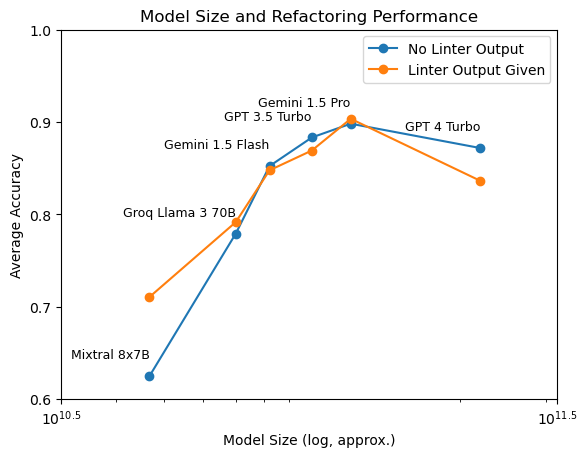

In [13]:
plt.figure()
plt.plot(MODEL_SIZES, refactor_no_linter_avg_scores, marker='o', label='No Linter Output')
plt.plot(MODEL_SIZES, refactor_linter_avg_scores, marker='o', label='Linter Output Given')

plt.xscale('log')
plt.xticks(ticks=[10**10.49, 10**11.5], labels=['$10^{10.5}$', '$10^{11.5}$'])
plt.yticks(np.arange(0.6, 1.01, step=0.1))

for i, label in enumerate(MODEL_INDEXES.values()):
    plt.text(MODEL_SIZES[i], refactor_no_linter_avg_scores[i] + 0.03, label, fontsize=9, ha='right', va='top')

plt.xlabel('Model Size (log, approx.)')
plt.ylabel('Average Accuracy')
plt.title('Model Size and Refactoring Performance')
plt.legend()

plt.show()

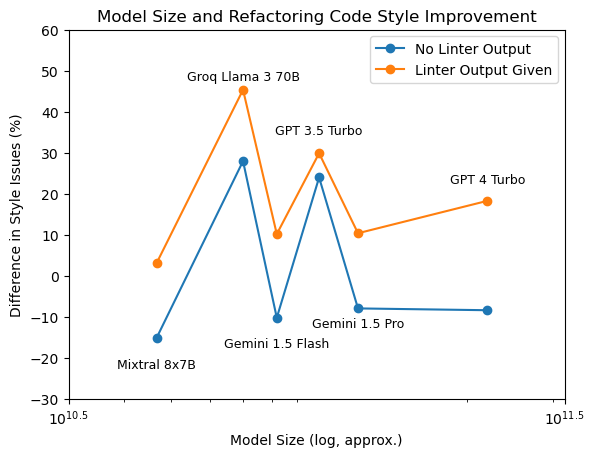

In [14]:
plt.figure()
plt.plot(MODEL_SIZES, refactor_no_linter_style_improvement, marker='o', label='No Linter Output')
plt.plot(MODEL_SIZES, refactor_linter_style_improvement, marker='o', label='Linter Output Given')

plt.xscale('log')
plt.xticks(ticks=[10**10.49, 10**11.5], labels=['$10^{10.5}$', '$10^{11.5}$'])
plt.yticks(np.arange(-30, 60.1, step=10))

y_positions = [-20, 50, -15, 37, -10, 25]
for i, label in enumerate(MODEL_INDEXES.values()):
    plt.text(MODEL_SIZES[i], y_positions[i], label, fontsize=9, ha='center', va='top')

plt.xlabel('Model Size (log, approx.)')
plt.ylabel('Difference in Style Issues (%)')
plt.title('Model Size and Refactoring Code Style Improvement')
plt.legend()

plt.show()

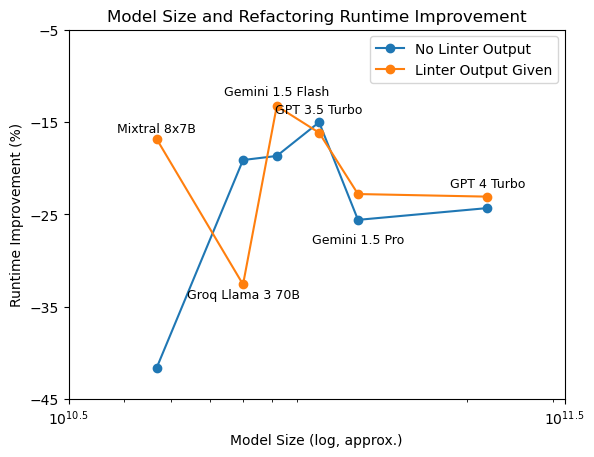

In [15]:
plt.figure()
plt.plot(MODEL_SIZES, refactor_no_linter_avg_runtime_improvement, marker='o', label='No Linter Output')
plt.plot(MODEL_SIZES, refactor_linter_avg_runtime_improvement, marker='o', label='Linter Output Given')

plt.xscale('log')
plt.xticks(ticks=[10**10.49, 10**11.5], labels=['$10^{10.5}$', '$10^{11.5}$'])
plt.yticks(np.arange(-45, 0.1, step=10))

y_positions = [-15, -33, -11, -13, -27, -21]
for i, label in enumerate(MODEL_INDEXES.values()):
    plt.text(MODEL_SIZES[i], y_positions[i], label, fontsize=9, ha='center', va='top')

plt.xlabel('Model Size (log, approx.)')
plt.ylabel('Runtime Improvement (%)')
plt.title('Model Size and Refactoring Runtime Improvement')
plt.legend()

plt.show()

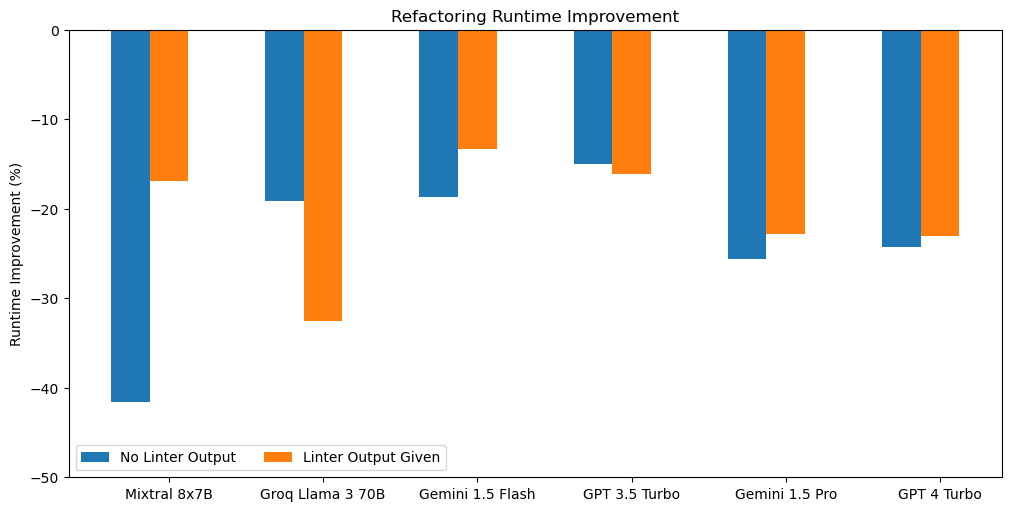

In [16]:
bar_means = {
    'No Linter Output': refactor_no_linter_avg_runtime_improvement,
    'Linter Output Given': refactor_linter_avg_runtime_improvement,
}

x = np.arange(len(MODEL_INDEXES.values()))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,5))

for attribute, measurement in bar_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Runtime Improvement (%)')
ax.set_title('Refactoring Runtime Improvement')
ax.set_xticks(x + width, MODEL_INDEXES.values())
ax.legend(loc='lower left', ncols=3)
ax.set_ylim(-50, 0)

plt.show()

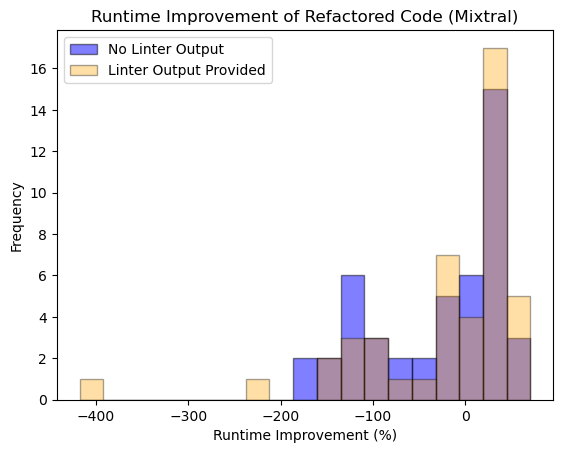

In [17]:
no_linter_runtime_df = load_evaluation(REFACTOR_NO_LINTER_EVALUATIONS[4]) # Gemini 1.5 Pro
no_linter_runtime_df['runtime_improvement'] = ((no_linter_runtime_df['runtimeOriginal'] - no_linter_runtime_df['runtimeRefactored']) / no_linter_runtime_df['runtimeOriginal']) * 100
no_linter_runtime_df = no_linter_runtime_df[no_linter_runtime_df['runtime_improvement'] > -500]

linter_runtime_df = load_evaluation(REFACTOR_LINTER_EVALUATIONS[4]) # Gemini 1.5 Pro
linter_runtime_df['runtime_improvement'] = ((linter_runtime_df['runtimeOriginal'] - linter_runtime_df['runtimeRefactored']) / linter_runtime_df['runtimeOriginal']) * 100
linter_runtime_df = linter_runtime_df[linter_runtime_df['runtime_improvement'] > -500]


min_bin = min(no_linter_runtime_df['runtime_improvement'].min(), linter_runtime_df['runtime_improvement'].min())
max_bin = max(no_linter_runtime_df['runtime_improvement'].max(), linter_runtime_df['runtime_improvement'].max())
bins = np.linspace(min_bin, max_bin, 20)

plt.hist(no_linter_runtime_df['runtime_improvement'], bins=bins, alpha=0.5, label='No Linter Output', color='blue', edgecolor='black')
plt.hist(linter_runtime_df['runtime_improvement'], bins=bins, alpha=0.35, label='Linter Output Provided', color='orange', edgecolor='black')

plt.legend()
plt.xlabel('Runtime Improvement (%)')
plt.ylabel('Frequency')
plt.title('Runtime Improvement of Refactored Code (Mixtral)')

plt.show()

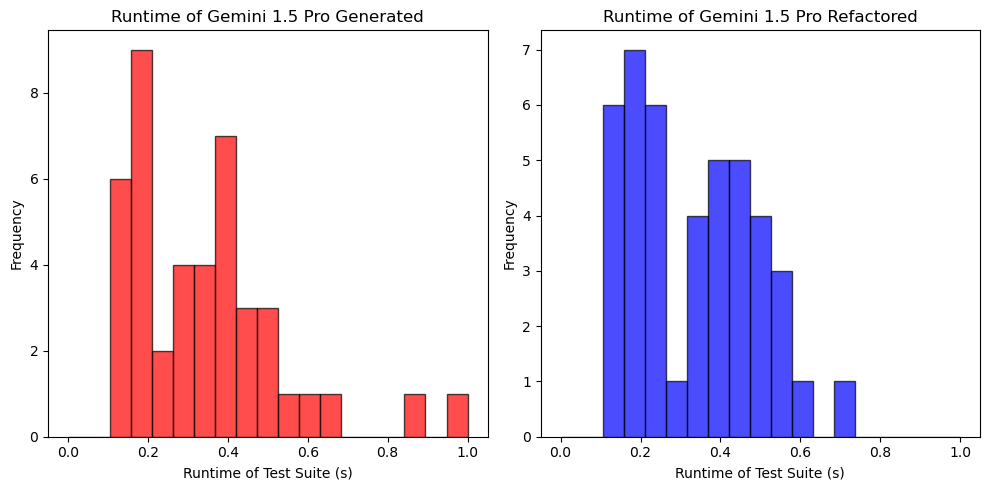

In [18]:
bins = np.linspace(0, 1, 20)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms
axes[0].hist(code_quality_df['runtimeRefactored'], bins=bins, color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Runtime of Gemini 1.5 Pro Generated')
axes[0].set_xlabel('Runtime of Test Suite (s)')
axes[0].set_ylabel('Frequency')

axes[1].hist(no_linter_runtime_df['runtimeRefactored'], bins=bins, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_title('Runtime of Gemini 1.5 Pro Refactored')
axes[1].set_xlabel('Runtime of Test Suite (s)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()